In [1]:
import os, glob 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import choice

In [2]:
imgs_fps = {year.strip(): sorted(glob.glob(f"{year}/images/*/*.png")) for year in sorted(os.listdir('.')) if year.strip().isnumeric()}

In [3]:
sample_imgs ={year: cv2.cvtColor(cv2.imread(choice(fps)), cv2.COLOR_BGR2RGB) for year, fps in imgs_fps.items()} 

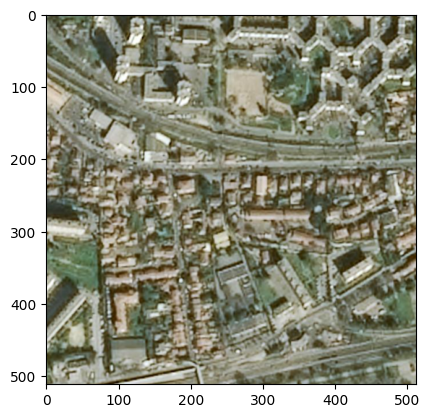

In [4]:
img = sample_imgs['2014']
plt.imshow(img)

In [6]:
def plot_img_hist(img):
    # Plotting color histograms
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('image')
    plt.axis('off')
    plt.subplot(1,2,2)
    for i, col in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)

    plt.title('Color Histogram')
    plt.xlabel('Pixel Values')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

In [194]:
def average_histogram_year(references):
    """Compute the average color distribution from multiple images."""
    imgs = [cv2.cvtColor(cv2.imread(ref), cv2.COLOR_BGR2LAB) for ref in references]
    stds = [img.std(axis=(0,1)) for img in imgs]
    means = [img.mean(axis=(0,1)) for img in imgs]
    stds= np.stack(stds, axis=0)
    means = np.stack(means, axis= 0)
    
    return means.mean(axis=0), stds.mean(axis=0)

lab_means, lab_stds = average_histogram_year(imgs_fps['2015'])

In [20]:
profile = np.load('target_profile_2020.npz')
all_lab_means, all_lab_stds = profile['lab_means'], profile['lab_stds']

In [36]:
def color_transfer(source, LAB_means, LAB_stds, BGR = False ):
    """
    Transfers color distribution from the target to the source.
    """
    # Convert images to LAB color space
    src_lab = cv2.cvtColor(source, cv2.COLOR_RGB2LAB).astype(np.float32)
    if BGR :
        src_lab = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype(np.float32)
    l_src, a_src, b_src = cv2.split(src_lab)
    
    
    # Mean and std for each channel of source
    src_mean, a_src_mean, b_src_mean = src_lab.mean(axis=(0,1))
    src_std, a_src_std, b_src_std = src_lab.std(axis=(0,1))
    
    # Mean and std for each channel of target
    tar_mean, a_tar_mean, b_tar_mean = LAB_means
    tar_std, a_tar_std, b_tar_std = LAB_stds

    # Perform color transfer
    l_new = (l_src - src_mean) * (tar_std / src_std) + tar_mean
    a_new = (a_src - a_src_mean) * (a_tar_std / a_src_std) + a_tar_mean
    b_new = (b_src - b_src_mean) * (b_tar_std / b_src_std) + b_tar_mean
    
    # Clip to valid range
    l_new = np.clip(l_new, 0, 255)
    a_new = np.clip(a_new, 0, 255)
    b_new = np.clip(b_new, 0, 255)

    # Combine back into LAB
    transfer_lab = cv2.merge([l_new, a_new, b_new]).astype(np.uint8)

    # Convert back to RGB
    transfer = cv2.cvtColor(transfer_lab, cv2.COLOR_LAB2RGB)
    if BGR:
        transfer = cv2.cvtColor(transfer_lab, cv2.COLOR_LAB2BGR)

    return transfer



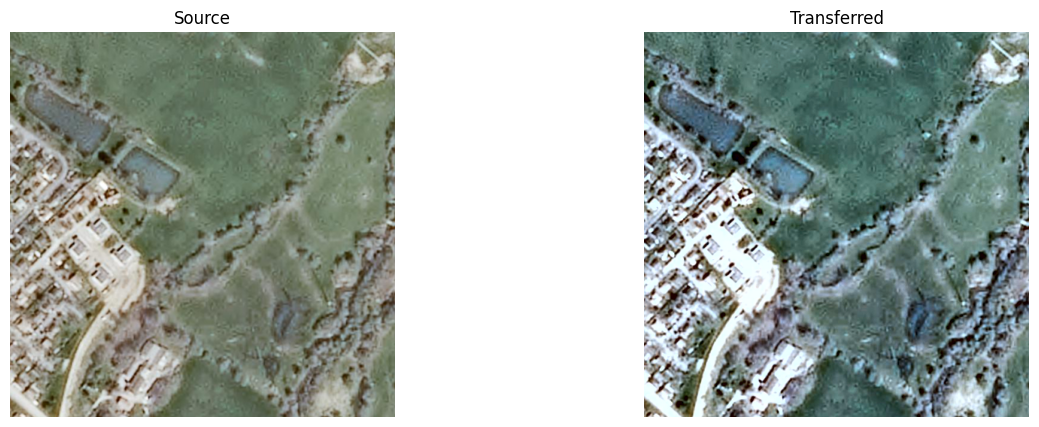

In [40]:

# Perform color transfer

profile = np.load('target_profile_2020.npz')
all_lab_means, all_lab_stds = profile['lab_means'], profile['lab_stds']

source = sample_imgs['2013']
result = color_transfer(source, all_lab_means, all_lab_stds)

# Display results side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title('Source')
axs[0].imshow(source)
axs[0].axis('off')


axs[1].set_title('Transferred')
axs[1].imshow(result)
axs[1].axis('off')

plt.show()

In [29]:
sample_imgs ={year: cv2.cvtColor(cv2.imread(choice(fps)), cv2.COLOR_BGR2RGB) for year, fps in imgs_fps.items()} 

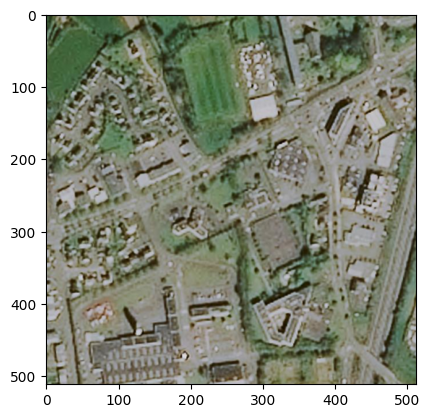

In [30]:
plt.imshow(sample_imgs['2021'])

In [31]:
for year in range(2013, 2026):
    
    if year == 2025:
        profile = np.load(f'target_profile.npz')
    else:
        profile = np.load(f'target_profile_{year}.npz')
    lab_means, lab_stds = profile['lab_means'], profile['lab_stds']
    plt.figure(figsize=(12,16))
    for y, img in sample_imgs.items():
        res = color_transfer(img, lab_means, lab_stds)
        full_img = np.hstack([img, res])
    
        # show
        plt.subplot(4,3,int(y) - 2012)
        plt.title(y)
        plt.imshow(full_img)
        plt.axis('off')
      
    plt.suptitle(f"{year} profile")  
    plt.tight_layout()
    plt.savefig(f'{year} profile result.png')
    plt.close()

In [ ]:
for year in range(2013, 2026):
    
    if year == 2025:
        profile = np.load(f'target_profile.npz')
    else:
        profile = np.load(f'target_profile_{year}.npz')
    lab_means, lab_stds = profile['lab_means'], profile['lab_stds']
    plt.figure(figsize=(12,16))
    for y, img in sample_imgs.items():
        res = color_transfer(img, lab_means, lab_stds)

        # show
        plt.subplot(4,3,int(y) - 2012)
        plt.title(y)
        plt.imshow(img)
        plt.axis('off')
      
    plt.suptitle(f"{year} profile")  
    plt.tight_layout()
    plt.savefig(f'{year} profile result only.png')
    plt.close()

In [33]:
plt.figure(figsize=(12,16))
for y, img in sample_imgs.items():

    # show
    plt.subplot(4,3,int(y) - 2012)
    plt.title(y)
    plt.imshow(img)
    plt.axis('off')
      
plt.suptitle(f"profiles")  
plt.tight_layout()
plt.savefig(f'images.png')
plt.close()

In [41]:
profile = np.load(f'target_profile_2015.npz')
lab_means, lab_stds = profile['lab_means'], profile['lab_stds']
for img_fp in glob.glob('/home/adelb/Pictures/qgis/nwe-spot-data/data/images/*.jpg'):
    fn = os.path.basename(img_fp)
    img = cv2.imread(img_fp)
    res = color_transfer(img, lab_means, lab_stds, True)
    
    cv2.imwrite(f'/home/adelb/Pictures/qgis/nwe-spot-data/data/prep-images-2015/{fn}', res)

In [44]:

images_fps = glob.glob('/home/adelb/Pictures/qgis/nwe-spot-data/data/images/*.jpg')
def get_prep_img_fp(img_fp):
    fn = os.path.basename(img_fp)
    return f"/home/adelb/Pictures/qgis/nwe-spot-data/data/prep-images-2015/{fn}"

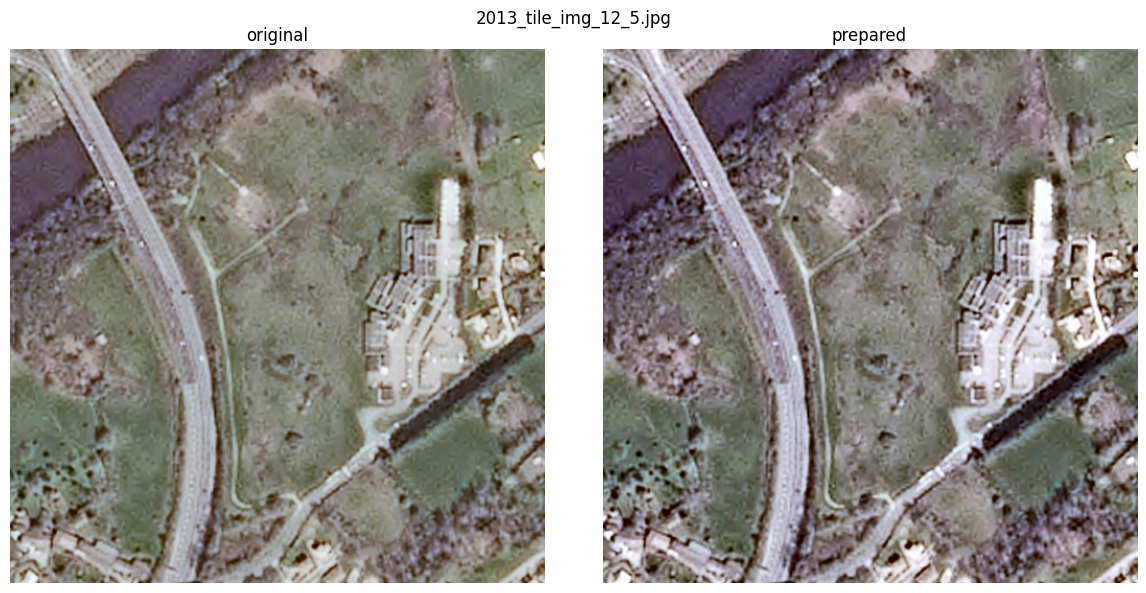

In [61]:
img_fp = choice(images_fps)
prep_img_fp = get_prep_img_fp(img_fp)

img = cv2.cvtColor(cv2.imread(img_fp), cv2.COLOR_BGR2RGB)
prep_img = cv2.cvtColor(cv2.imread(prep_img_fp), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(prep_img)
plt.title('prepared')
plt.axis('off')

plt.suptitle(os.path.basename(img_fp))
plt.tight_layout()
plt.show()